# Parsing Experiment Results

In this notebook, we will be parsing the results of running `experiment.ipynb` from our `results` folder.

In [1]:
# configs
results_name = 'bench1_sleep_rand2_1000_200'
results_folder = './results/'
results_logger_glob = f'{results_folder}{results_name}/*_logger.csv'
results_reqs_glob = f'{results_folder}{results_name}/*_reqs.csv'

print(results_logger_glob)
print(results_reqs_glob)

./results/bench1_sleep_rand2_1000_200/*_logger.csv
./results/bench1_sleep_rand2_1000_200/*_reqs.csv


In [2]:
# plotting imports (needs to be before matplotlib)
import pacsltk.pacs_util as pacs_util
pacs_util.prepare_matplotlib_cycler()

# general imports
import os

# parsing imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# other seaborn aesthetic options: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set_style("whitegrid")

# for datetime analysis
from datetime import datetime, timedelta
import pytz

my_timezone = os.getenv('PY_TZ', 'America/Toronto')

# for file processing
import glob
import json

# for better printing of variables
from IPython.display import display

In [3]:
# utility functions

In [4]:
# Prepare for plots and make directories
figs_folder = "./figs/"
!mkdir -p {figs_folder}

def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
              x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

def parse_epoch_cols(df, epoch_cols_list):
    for epoch_col in epoch_cols_list:
        times = df[epoch_col].apply(lambda x: datetime.fromtimestamp(x).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None))
        times = pd.to_datetime(times.dt.to_pydatetime())
        df[epoch_col + '_dt'] = times

# Developing Analysis of Logger Data

In [5]:
# get a list of logger files and sort them
logger_file_list = glob.glob(results_logger_glob)
logger_file_list.sort()

# logger_file_list

,ready_count,total_conc,conc_window_average,time,rps,target,lambda_over_n,current_cc
time_dt,,,,,,,,
2021-02-25 16:27:25.005767,2,0,0.541667,1.614288e+09,1,1,0.5,0.0
2021-02-25 16:27:27.007128,2,0,0.550000,1.614288e+09,1,1,0.5,0.0
2021-02-25 16:27:29.008358,2,1,0.533333,1.614288e+09,1,1,0.5,0.5
2021-02-25 16:27:31.013211,2,0,0.516667,1.614288e+09,1,1,0.5,0.0
2021-02-25 16:27:33.020628,2,1,0.541667,1.614288e+09,1,1,0.5,0.5


<AxesSubplot:xlabel='time_dt'>

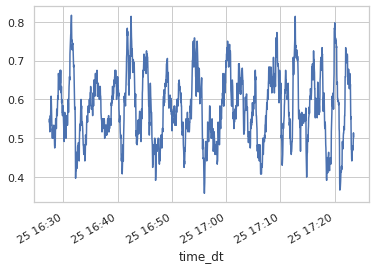

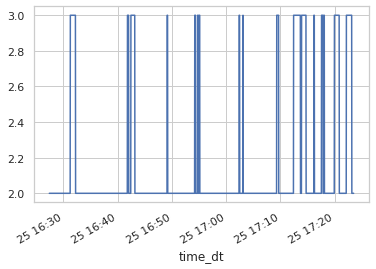

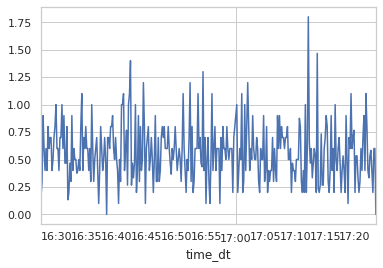

In [6]:
parse_skip_mins = 5

def parse_logger_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['time', ])
    # skip 5 minutes
    df = df[df['time_dt'] > df['time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    df['lambda_over_n'] = df['rps'] / df['ready_count']
    df['current_cc'] = df['total_conc'] / df['ready_count']
    # set index to the time
    df = df.set_index('time_dt')
    return df


df = parse_logger_file(logger_file_list[0])
display(df.head())

plt.figure()
df['conc_window_average'].plot()
plt.figure()
df['ready_count'].plot()
plt.figure()
df['current_cc'].resample('10s').mean().plot()

## Analyze Experiment-By-Experiment Results

100%|██████████| 48/48 [00:01<00:00, 34.39it/s]


,conc_window_average_mean,arrival_rate,average_ready_count,cc
0,0.578613,1,2.132222,1
1,0.643642,2,3.922383,1
2,0.666654,3,5.704532,1
3,0.680760,5,9.059286,1
4,0.692533,7,12.334343,1


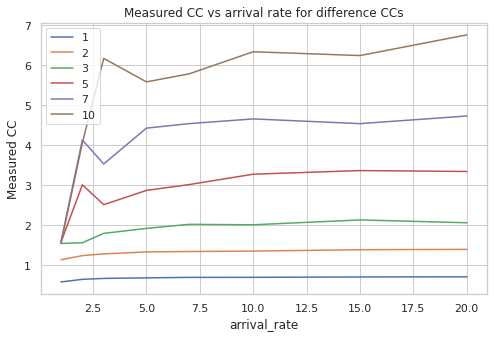

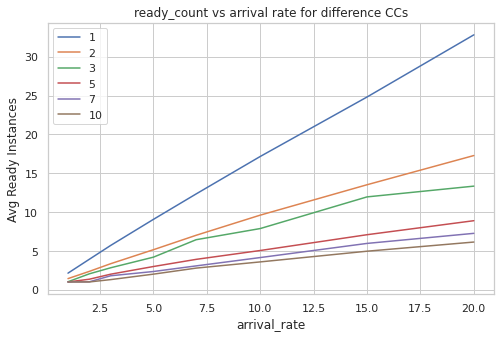

In [8]:
results_arr = []
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    arrival_rate = df['rps'][0]
    cc = df['target'][0]

    results_arr.append({
        'conc_window_average_mean': df['conc_window_average'].mean(),
        'arrival_rate': arrival_rate,
        'average_ready_count': df['ready_count'].mean(),
        'cc': cc,
    })

df_logger_result = pd.DataFrame(data=results_arr)
display(df_logger_result.head())

plt.figure(figsize=(8,5))
df_logger_result.set_index('arrival_rate').groupby('cc')['conc_window_average_mean'].plot()
plt.title('Measured CC vs arrival rate for difference CCs')
plt.ylabel('Measured CC')
plt.legend()
plt.figure(figsize=(8,5))
df_logger_result.set_index('arrival_rate').groupby('cc')['average_ready_count'].plot()
plt.title('ready_count vs arrival rate for difference CCs')
plt.ylabel('Avg Ready Instances')
plt.legend()

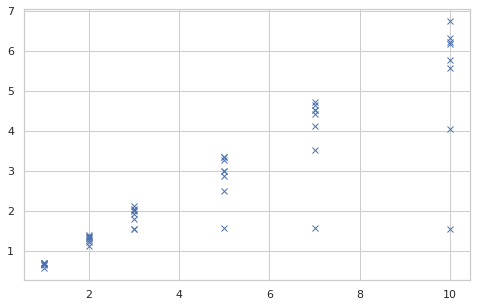

In [9]:
# plotting the set concurrency vs the measured concurrency
plt.figure(figsize=(8,5))
plt.plot(df_logger_result['cc'], df_logger_result['conc_window_average_mean'], 'x')

## Analyze Merged Results

100%|██████████| 48/48 [00:01<00:00, 26.30it/s]


,ready_count,total_conc,conc_window_average,time,rps,target,current_cc
lambda_over_n,,,,,,,
0.333333,3.000000,1.121622,0.665165,1.614291e+09,1.000000,1.000000,0.373874
0.400000,5.000000,2.565789,0.746827,1.614294e+09,2.000000,1.000000,0.513158
0.428571,7.000000,3.621212,0.727680,1.614297e+09,3.000000,1.000000,0.517316
0.454545,11.000000,4.428571,0.825572,1.614300e+09,5.000000,1.000000,0.402597
0.500000,3.962696,2.399920,0.726370,1.614298e+09,1.981348,1.161252,0.608392


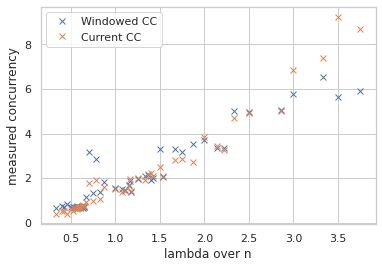

In [10]:
df_logger_merged = pd.DataFrame()
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    df_logger_merged = df_logger_merged.append(df)


df_logger_merged_lon = df_logger_merged.groupby('lambda_over_n').mean()
display(df_logger_merged_lon.head())
# let's analyze the relationship between conc_window_average and lambda_over_n
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['conc_window_average'], 'x', label='Windowed CC')
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['current_cc'], 'x', label='Current CC')
plt.xlabel('lambda over n')
plt.ylabel('measured concurrency')
plt.legend()

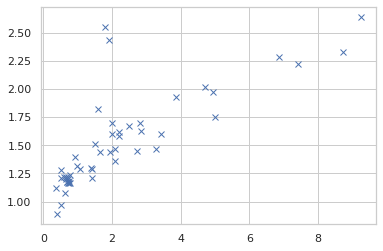

In [11]:
# this tries to model average service time as a function of average number of requests in each container
# plt.plot(df_logger_merged_lon['conc_window_average'], df_logger_merged_lon['conc_window_average'] / df_logger_merged_lon.index, 'x')
plt.plot(df_logger_merged_lon['current_cc'], df_logger_merged_lon['current_cc'] / df_logger_merged_lon.index, 'x')

Now, let's try and see we can see any relationship between $\lambda/N$ and the $\mu$ and $\sigma$ of the measured concurrency.

In [12]:
tmp_res = []
for lambda_over_n in df_logger_merged['lambda_over_n'].unique():
    sub_df = df_logger_merged.loc[df_logger_merged['lambda_over_n'] == lambda_over_n, :]
    if len(sub_df) > 10:
        tmp_res.append({
            'lambda_over_n': lambda_over_n,
            'conc_window_average_mean': np.mean(sub_df['conc_window_average']),
            'conc_window_average_std': np.std(sub_df['conc_window_average']),
            'current_cc_mean': sub_df['current_cc'].mean(),
            'current_cc_std': np.std(sub_df['current_cc']),
        })
    # if len(sub_df) > 400:
    #     plt.figure()
    #     plt.hist(sub_df['conc_window_average'], bins=20)

tmpdf = pd.DataFrame(data=tmp_res)

average std to mean windowed 0.13042800956982353
average std to mean 0.3915030019180665
std to std ratio 4.727040738101256
7.745966692414834


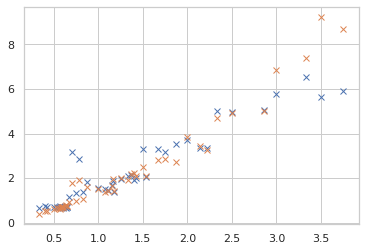

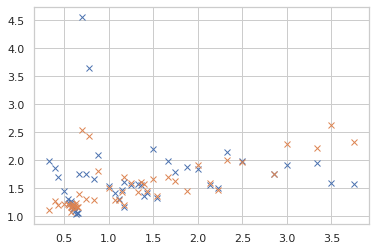

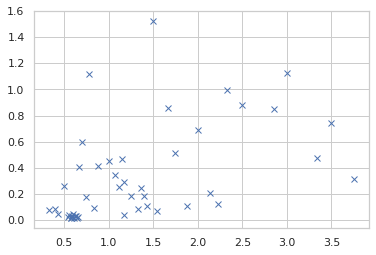

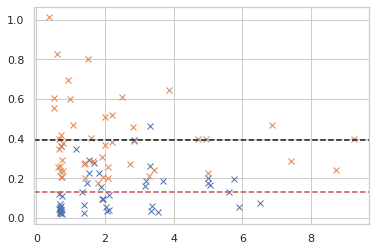

In [13]:
conc_avg_std_to_mean = (tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean']).mean()
current_cc_std_to_mean = (tmpdf['current_cc_std'] / tmpdf['current_cc_mean']).mean()
print("average std to mean windowed", conc_avg_std_to_mean)
print("average std to mean", current_cc_std_to_mean)
print("std to std ratio", (tmpdf['current_cc_std'] / tmpdf['conc_window_average_std']).mean())
print(np.sqrt(60))

plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_mean'], 'x')
plt.plot(tmpdf['lambda_over_n'], tmpdf['current_cc_mean'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_mean'] / tmpdf['lambda_over_n'], 'x')
plt.plot(tmpdf['lambda_over_n'], tmpdf['current_cc_mean'] / tmpdf['lambda_over_n'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'], 'x')
plt.figure()
# plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean'], 'x')
# plt.plot(tmpdf['lambda_over_n'], tmpdf['current_cc_std'] / tmpdf['current_cc_mean'], 'x')
plt.plot(tmpdf['conc_window_average_mean'], tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean'], 'x')
plt.plot(tmpdf['current_cc_mean'], tmpdf['current_cc_std'] / tmpdf['current_cc_mean'], 'x')
plt.axhline(y=conc_avg_std_to_mean, c='r', ls='--')
plt.axhline(y=current_cc_std_to_mean, c='k', ls='--')

### Try Fitting a Line To Measured Concurrency

In [14]:
x = df_logger_merged_lon.index.values
# y = df_logger_merged_lon['conc_window_average'].values
y = df_logger_merged_lon['current_cc'].values

# reshape for sklearn
x = x.reshape(-1, 1)

[0.0, 0.9967677619555573, 0.3792301625579139]


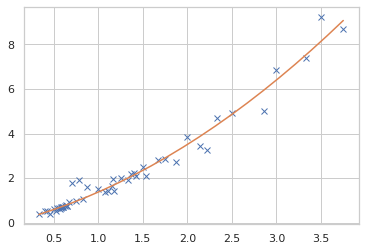

In [15]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

inputProcess = lambda x: np.array([x,x**2]).squeeze().T

plt_x = np.linspace(x.min(), x.max(), 20)
plt_x = plt_x.reshape(-1, 1)


# preprocess input
ix = inputProcess(x)
iplt_x = inputProcess(plt_x)

# Create linear regression object
# regr = linear_model.LinearRegression()
# no intercept might be better because when lambda over n is zero, conc is zero
regr = linear_model.LinearRegression(fit_intercept=False)
# Train the model using the training sets
regr.fit(ix, y)

print([regr.intercept_] + list(regr.coef_))

plt_y = regr.predict(iplt_x)

plt.plot(x,y,'x')
plt.plot(plt_x, plt_y)

In [16]:
# single_point_predict = lambda x: regr.predict(inputProcess(np.array([x]).reshape(-1,1)))[0]

# # xmin = x.min()
# xmin = x.min() + 0.25 * (x.max() - x.min())
# xmax = x.max()

# w1 = single_point_predict(xmin) / xmin
# w2 = single_point_predict(xmax) / xmax

# alpha = (w2 - w1) / (xmax - xmin)
# print(w1, w2, alpha)

In [17]:
# coeffs = [-0.70, 2.08]
# plt_y = plt_x * coeffs[1] + coeffs[0]

# plt.plot(x,y,'x')
# plt.plot(plt_x, plt_y)

# coeffs2 = [0.2247, 0.5306512, 0.46373073]
# plt_y = (plt_x ** 2) * coeffs2[2] + plt_x * coeffs2[1] + coeffs2[0]

# plt.plot(plt_x, plt_y)

# Developing Analysis of Requests Results

In [18]:
reqs_file_list = glob.glob(results_reqs_glob)
reqs_file_list.sort()

,client_start_time,client_end_time,client_elapsed_time,start_conc,end_conc,success,start_ready_count,end_ready_count,rps,target,client_end_time_dt,lambda_over_n
client_start_time_dt,,,,,,,,,,,,
2021-02-25 16:27:25.218674,1.614288e+09,1.614288e+09,1.218477,1,1,True,2,2,1,1,2021-02-25 16:27:26.437151,0.5
2021-02-25 16:27:27.227411,1.614288e+09,1.614288e+09,1.115793,1,2,True,2,2,1,1,2021-02-25 16:27:28.343204,0.5
2021-02-25 16:27:28.071798,1.614288e+09,1.614288e+09,1.106980,2,1,True,2,2,1,1,2021-02-25 16:27:29.178778,0.5
2021-02-25 16:27:31.070470,1.614288e+09,1.614288e+09,1.267028,1,2,True,2,2,1,1,2021-02-25 16:27:32.337498,0.5
2021-02-25 16:27:31.903678,1.614288e+09,1.614288e+09,1.174564,2,1,True,2,2,1,1,2021-02-25 16:27:33.078242,0.5


<AxesSubplot:xlabel='client_start_time_dt'>

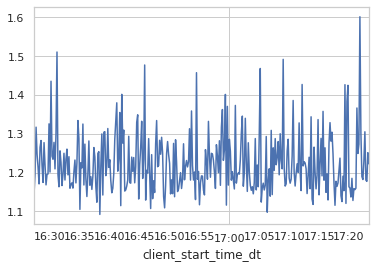

In [19]:
def parse_reqs_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['client_start_time', 'client_end_time' ])
    # skip 5 minutes
    df = df[df['client_start_time_dt'] > df['client_start_time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    df['lambda_over_n'] = df['rps'] / df['start_ready_count']
    # # set index to the time
    df = df.set_index('client_start_time_dt')
    return df


df = parse_reqs_file(reqs_file_list[0])
display(df.head())

plt.figure()
df['client_elapsed_time'].resample('10s').mean().plot()

## Analyze Experiment-By-Experiment Results

In [21]:
results_arr = []
for file_path in tqdm(reqs_file_list):
    df = parse_reqs_file(file_path)
    arrival_rate = df['rps'][0]
    cc = df['target'][0]

    results_arr.append({
        'arrival_rate': arrival_rate,
        'average_resp_time': df['client_elapsed_time'].mean(),
        'average_ready_count': df['start_ready_count'].mean(),
        'lambda_over_n': df['lambda_over_n'].mean(),
        'cc': cc,
    })

df_reqs_result = pd.DataFrame(data=results_arr)
display(df_reqs_result.head())


100%|██████████| 48/48 [00:29<00:00,  1.63it/s]


,arrival_rate,average_resp_time,average_ready_count,lambda_over_n,cc
0,1,1.239461,2.137878,0.477020,1
1,2,1.246276,3.919613,0.516641,1
2,3,1.241389,5.706744,0.530867,1
3,5,1.227566,9.052914,0.554590,1
4,7,1.216340,12.330941,0.569108,1


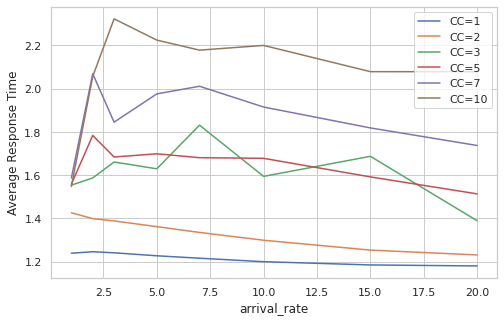

In [22]:
# plt.plot(df_reqs_result['arrival_rate'], df_reqs_result['average_resp_time'])
# relationship between arrival rate and response time
plt.figure(figsize=(8,5))
for cc in df_reqs_result['cc'].unique():
    sub_df = df_reqs_result[df_reqs_result['cc'] == cc]
    tmpdf = sub_df.set_index('arrival_rate')
    tmpdf['average_resp_time'].plot(label=f"CC={cc}")
    
plt.ylabel('Average Response Time')
plt.legend()

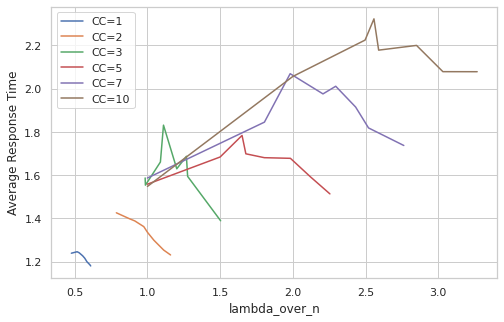

In [23]:
# check for relationships between lambda/N and average response time
plt.figure(figsize=(8,5))
for cc in df_reqs_result['cc'].unique():
    tmpdf = df_reqs_result[df_reqs_result['cc'] == cc]
    tmpdf.groupby('lambda_over_n').mean()['average_resp_time'].plot(label=f"CC={cc}")
    
plt.ylabel('Average Response Time')
plt.legend()

## Analyze Merged Results

In [34]:
df_reqs_merged = pd.DataFrame()
for file_path in tqdm(reqs_file_list):
    df = parse_reqs_file(file_path)
    df_reqs_merged = df_reqs_merged.append(df)


tmpdf = df_reqs_merged.groupby('lambda_over_n').mean()
display(tmpdf.head())

100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


,client_start_time,client_end_time,client_elapsed_time,start_conc,end_conc,success,start_ready_count,end_ready_count,rps,target
lambda_over_n,,,,,,,,,,
0.333333,1.614291e+09,1.614291e+09,1.199517,2.239468,2.281596,True,3.000000,2.971175,1.000000,1.000000
0.400000,1.614293e+09,1.614293e+09,1.211112,3.416149,3.413043,True,5.000000,4.931677,2.000000,1.000000
0.428571,1.614297e+09,1.614297e+09,1.210119,4.628141,4.613065,True,7.000000,6.881910,3.000000,1.000000
0.454545,1.614300e+09,1.614300e+09,1.177768,5.080000,4.840000,True,11.000000,10.920000,5.000000,1.000000
0.500000,1.614298e+09,1.614298e+09,1.237965,4.262204,4.265462,True,5.353321,5.333774,2.676661,1.081751


target
1.000000     AxesSubplot(0.125,0.125;0.775x0.755)
1.081751     AxesSubplot(0.125,0.125;0.775x0.755)
1.817060     AxesSubplot(0.125,0.125;0.775x0.755)
1.987985     AxesSubplot(0.125,0.125;0.775x0.755)
2.000000     AxesSubplot(0.125,0.125;0.775x0.755)
2.076286     AxesSubplot(0.125,0.125;0.775x0.755)
2.124270     AxesSubplot(0.125,0.125;0.775x0.755)
2.382399     AxesSubplot(0.125,0.125;0.775x0.755)
2.630665     AxesSubplot(0.125,0.125;0.775x0.755)
2.824604     AxesSubplot(0.125,0.125;0.775x0.755)
2.882814     AxesSubplot(0.125,0.125;0.775x0.755)
2.934888     AxesSubplot(0.125,0.125;0.775x0.755)
3.000000     AxesSubplot(0.125,0.125;0.775x0.755)
3.004772     AxesSubplot(0.125,0.125;0.775x0.755)
5.000000     AxesSubplot(0.125,0.125;0.775x0.755)
5.021481     AxesSubplot(0.125,0.125;0.775x0.755)
5.134856     AxesSubplot(0.125,0.125;0.775x0.755)
5.218486     AxesSubplot(0.125,0.125;0.775x0.755)
5.436232     AxesSubplot(0.125,0.125;0.775x0.755)
6.029236     AxesSubplot(0.125,0.125;0.775x

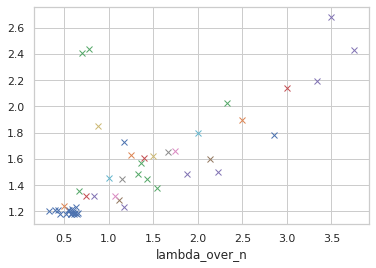

In [36]:
tmpdf.groupby('target')['client_elapsed_time'].plot(style='x')
# plt.legend()

,lambda_over_n,resp_time_avg
0,0.500000,1.237965
1,0.333333,1.199517
2,0.666667,1.354514
3,0.400000,1.211112
4,0.428571,1.210119


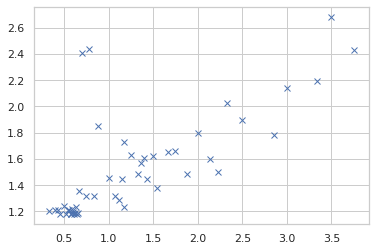

In [37]:
tmp_res = []
for lambda_over_n in df_reqs_merged['lambda_over_n'].unique():
    sub_df = df_reqs_merged.loc[df_reqs_merged['lambda_over_n'] == lambda_over_n, :]
    if len(sub_df) > 10:
        tmp_res.append({
            'lambda_over_n': lambda_over_n,
            'resp_time_avg': np.mean(sub_df['client_elapsed_time']),
        })

tmpdf = pd.DataFrame(data=tmp_res)
display(tmpdf.head())

plt.plot(tmpdf['lambda_over_n'], tmpdf['resp_time_avg'], 'x')

In [38]:
x = tmpdf['lambda_over_n']
y = tmpdf['resp_time_avg']

[1.204059745006787, 0.16858548321943162, 0.044656610021255004]


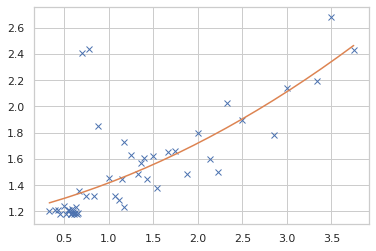

In [39]:
inputProcess = lambda x: np.array([x,x**2]).squeeze().T

plt_x = np.linspace(x.min(), x.max(), 20)
plt_x = plt_x.reshape(-1, 1)


# preprocess input
ix = inputProcess(x)
iplt_x = inputProcess(plt_x)

# Create linear regression object
# regr = linear_model.LinearRegression()
# no intercept might be better because when lambda over n is zero, conc is zero
regr = linear_model.LinearRegression(fit_intercept=True)
# Train the model using the training sets
regr.fit(ix, y)

print([regr.intercept_] + list(regr.coef_))

plt_y = regr.predict(iplt_x)

plt.plot(x,y,'x')
plt.plot(plt_x, plt_y)

# Plots for Analyzing Effect of Concurrency

,conc_window_average_mean,arrival_rate,average_ready_count,cc
7,0.707114,20,32.819175,1
15,1.392329,20,17.276699,2
23,2.058221,20,13.337379,3
31,3.340280,20,8.887136,5
39,4.726848,20,7.258495,7


,arrival_rate,average_resp_time,average_ready_count,lambda_over_n,cc
7,20,1.180644,32.817167,0.609964,1
15,20,1.231449,17.270209,1.159134,2
23,20,1.389314,13.338056,1.503484,3
31,20,1.513507,8.885009,2.254833,5
39,20,1.737036,7.263598,2.763001,7


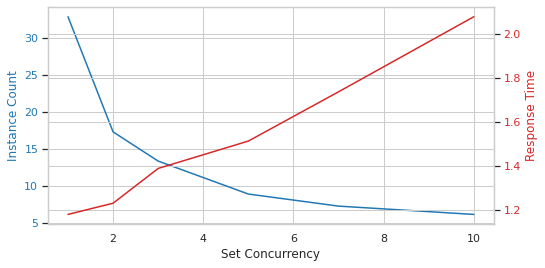

In [40]:
# let's see if we can make plots for effect of CC
plot_arrival_rate = 20

sub_df1 = df_logger_result[df_logger_result['arrival_rate'] == plot_arrival_rate]
sub_df2 = df_reqs_result[df_reqs_result['arrival_rate'] == plot_arrival_rate]
display(sub_df1.head())
display(sub_df2.head())

plt.figure(figsize=(8,4))
color = 'tab:blue'
ax1 = plt.gca()
ax1.plot(sub_df1['cc'], sub_df1['average_ready_count'], color=color)
ax1.set_xlabel('Set Concurrency')
ax1.set_ylabel('Instance Count', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = plt.gca().twinx()
ax2.plot(sub_df2['cc'], sub_df2['average_resp_time'], color)
ax2.set_ylabel('Response Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)